In [5]:
import numpy as np
#from LogGabor import LogGaborFit
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
import pickle
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
import torch.nn.functional as f

from  SDPC_PCB.DataTools import DataBase, ssim
from SDPC_PCB.Network import LayerPC, Network
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
from SDPC_PCB.DataTools import DataBase
from SDPC_PCB.Monitor import Monitor
from SDPC_PCB.Optimizers import mySGD, myAdam
import torch.nn.functional as f
import torch.nn as nn
import torch
import time
import tensorboardX
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torchvision.utils import make_grid
import numpy as np
from tensorboardX import SummaryWriter
import pickle
from torchvision.transforms import ToTensor, Compose, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from SDPC_PCB.Monitor import Monitor
from torchvision.datasets import STL10
import math

import matplotlib.pyplot as plt
cmap1=plt.get_cmap('tab20c')
from scipy.stats import wilcoxon
from decimal import Decimal

In [6]:
def show(img,figsize=(10,10)):
    npimg = img.numpy()
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt

def show_ax(img,ax):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    return ax

def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

In [7]:
data_path = '../DataSet/STL10'
batch_size=40
transform = Compose([Resize((120,120)),
                    ToTensor(),
                    to_cuda(),
                    whitening((120,120),f_0=0.8,n=3),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((120,120))])
                     

dataset = STL10(data_path, transform=transform, download=False, split='train')

DataBase = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Inference with different noise level and feedback strength

## Noise Robustness

In [9]:
where = 'Savings/STL/'
model_name = 'STL_[0.4,1.6]_b=1.pkl'
feedback_list = [0,1,2,3,4]


std_list = [0,1,2,3,4,5]
all_reco = torch.zeros(len(std_list),len(feedback_list),2,batch_size,3,120,120)
noisy_input = torch.zeros(len(std_list),batch_size,3,120,120)
nb_image = 1200#100
all_ssim = torch.zeros(nb_image,len(std_list),len(feedback_list),2)
ssim_baseline = torch.zeros(nb_image,len(std_list))

for k_FB in feedback_list:
    model_type = model_name[0:8]
    name = model_name
    print(name)

    path = where + name
    with open(path, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    for i in range(Net.nb_layers):
        Net.layers[i].b = k_FB
    Loss = ML_Lasso(Net, [0.4,1.6])
    Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=1e-4, mode='eigen', accell=True)
    for noise_idx, std in enumerate(std_list):
        k=0
        for idx_batch, data in enumerate(DataBase):
            image_ori = data[0].cuda()
            batch = data[0].cuda() + std*torch.randn(data[0].size()).cuda()

            gamma, it, Loss_G, delta = Pursuit.coding(batch)
            rec = reconstruction(Net,gamma)

            normalizer = image_ori.view(data[0].size(0),-1).max(dim=1)[0]
            normalized_image = image_ori.div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

            if k_FB == 0:
                normalizer_noisy = batch.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_noisy = batch.div(normalizer_noisy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

                ssim_baseline[k:k+batch.size(0),noise_idx] += ssim(normalized_image,normalized_noisy)
            for i in range(Net.nb_layers):
                normalizer = rec[i].view(data[0].size(0),-1).max(dim=1)[0]
                normalized_reco = rec[i].div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
                all_ssim[k:k+batch.size(0),noise_idx,k_FB,i] += ssim(normalized_image,normalized_reco)                
                all_reco[noise_idx,k_FB,i, :,:,:,:]=normalized_reco[:,:,:,:]
            noisy_input[noise_idx, :,:,:,:]=batch[:,:,:,:]


            print('total Image',k+batch.size(0)) 
            k+=batch.size(0)
            if k >= nb_image:
                break
                
Exp = {'model_name': feedback_list,
       'std_list':std_list,
        'ssim' : all_ssim,
        'reco':all_reco,
        'noisy_input':noisy_input,
        'ssim_baseline':ssim_baseline}


STL_[0.4,1.6]_b=1.pkl
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 440
total Image 480
total Image 520
total Image 560
total Image 600
total Image 640
total Image 680
total Image 720
total Image 760
total Image 800
total Image 840
total Image 880
total Image 920
total Image 960
total Image 1000
total Image 1040
total Image 1080
total Image 1120
total Image 1160
total Image 1200
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 440
total Image 480
total Image 520
total Image 560
total Image 600
total Image 640
total Image 680
total Image 720
total Image 760
total Image 800
total Image 840
total Image 880
total Image 920
total Image 960
total Image 1000
total Image 1040
total Image 1080
total Image 1120
total Image 1160
total Image 1200
total Imag

total Image 1040
total Image 1080
total Image 1120
total Image 1160
total Image 1200
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 440
total Image 480
total Image 520
total Image 560
total Image 600
total Image 640
total Image 680
total Image 720
total Image 760
total Image 800
total Image 840
total Image 880
total Image 920
total Image 960
total Image 1000
total Image 1040
total Image 1080
total Image 1120
total Image 1160
total Image 1200
STL_[0.4,1.6]_b=1.pkl
total Image 40
total Image 80
total Image 120
total Image 160
total Image 200
total Image 240
total Image 280
total Image 320
total Image 360
total Image 400
total Image 440
total Image 480
total Image 520
total Image 560
total Image 600
total Image 640
total Image 680
total Image 720
total Image 760
total Image 800
total Image 840
total Image 880
total Image 920
total Image 960
total Image 1000
total Imag

"\n    with open(path_saving, 'wb') as file:\n        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)\nelse : \n    with open(path_saving, 'rb') as file:\n        Exp = pickle.load(file)\n"

## Fig  10a

torch.Size([6, 5, 2, 3, 120, 120])
torch.Size([6, 3, 120, 120])
input


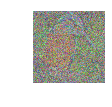

L1 -- fb=0


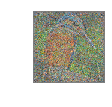

L1 -- fb=4


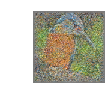

L2 -- fb=0


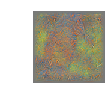

L2 -- fb=4


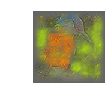

In [12]:
save_fig=False
idx_image = 37
model_name_list = Exp['model_name']
std_list = Exp['std_list']
all_reco = Exp['reco'][:,:,:,idx_image,:,:,:]
noisy_input = Exp['noisy_input'][:,idx_image,:,:,:]

print(all_reco.size())
print(noisy_input.size())

height = noisy_input.size(-2)
width = noisy_input.size(-1)

grid_param = {'padding':0, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':1}


print('input')
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img2 = make_grid(noisy_input[2],**grid_param)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    #plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10a_input.png', dpi= 3*height)
plt.show()


print('L1 -- fb=0')
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img2 = make_grid(all_reco[2,0,0,:,:,:],**grid_param)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig : 
    #plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10a_std=2_fb=0_layer1.png', dpi= 3*height)
plt.show()


print('L1 -- fb=4')
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img2 = make_grid(all_reco[2,-1,0,:,:,:],**grid_param)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig : 
    #plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10a_std=2_fb=4_layer1.png', dpi= 3*height)
plt.show()

print('L2 -- fb=0')
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img2 = make_grid(all_reco[2,0,1,:,:,:],**grid_param)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig : 
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10a_std=2_fb=0_layer2.png', dpi= 3*height)
plt.show()


print('L2 -- fb=4')
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
img2 = make_grid(all_reco[2,-1,1,:,:,:],**grid_param)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig : 
    #plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10a_std=2_fb=4_layer2.png', dpi= 3*height)
plt.show()

## Fig10b and c

tensor([0.0306, 0.0425, 0.0470, 0.0504, 0.0533])
tensor([0.0353, 0.0420, 0.0450, 0.0474, 0.0502])


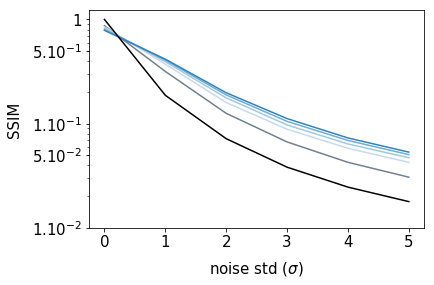

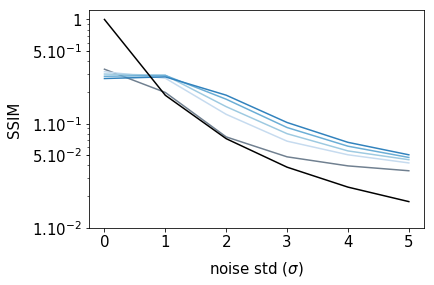

In [13]:
save_fig = False
#figsize = (6.4,5)
mean_ssim = Exp['ssim'].median(dim=0)[0]
print(mean_ssim[-1,:,0])
print(mean_ssim[-1,:,1])
mean_ssim_baseline = Exp['ssim_baseline'].median(dim=0)[0]

color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]
std_list = Exp['std_list']
b_list = np.arange(len(Exp['model_name']))

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    plt.plot(std_list ,mean_ssim[:,idx_b,0].numpy(),label='b={0}'.format(b),color=color[idx_b])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig10/Fig10b.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)
plt.show()

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    plt.plot(std_list, mean_ssim[:,idx_b,1].numpy(),label=r'$k_{FB}$'+ '={0}'.format(b), color=color[idx_b])
    
plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.ylabel('SSIM', fontsize=15, labelpad=10)
plt.yscale("log")
plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
if save_fig == True:
    plt.tight_layout()
    '''
    plt.savefig('Fig9/CFD_STL_legend.png',\
                bbox_inches = 'tight', pad_inches = 0.1, dpi= 400)
    '''
    plt.savefig('Savings/Fig/Fig10/Fig10c.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)

plt.show()    




## Fig S5a

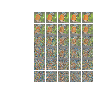

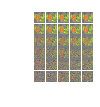

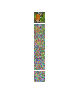

In [15]:
save_fig=False
idx_image = 37#23#18#2
model_name_list = Exp['model_name']
std_list = Exp['std_list']
all_reco = Exp['reco'][:,:,:,idx_image,:,:,:]
noisy_input = Exp['noisy_input'][:,idx_image,:,:,:]

#Exp = {'model_name': model_name_list,
#           'std_list':std_list,
#        'reco':all_reco,
#        'noisy_input':noisy_input}

total_patch_nb = len(std_list)*len(model_name_list)
#to_plot_reorganized = torch.zeros(total_patch_nb,3,96,96).cuda()
to_plot_reorganized = torch.zeros(total_patch_nb,3,120,120).cuda()




grid_param = grid_param = {'padding':8, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':len(model_name_list)}
### Plotting Layer 1 reconstruction
for i in std_list:
    to_plot_reorganized[i*len(model_name_list):(i+1)*len(model_name_list),:,:,:] = all_reco[i,:,0,:,:,:]
    
img2 = make_grid(to_plot_reorganized,**grid_param)

fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS5/FigS5a_layer1.png', dpi= height)
plt.show()


    
### Plotting Layer 2 reconstruction    
to_plot_reorganized = torch.zeros(total_patch_nb,3,120,120).cuda()
for i in std_list:
    to_plot_reorganized[i*len(model_name_list):(i+1)*len(model_name_list),:,:,:] = all_reco[i,:,1,:,:,:]
    
img2 = make_grid(to_plot_reorganized,**grid_param)

fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS5/FigS5a_layer2.png', dpi= height)
plt.show()

    
### Plotting the input
grid_param = grid_param = {'padding':8, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':1, 'scale_each':True}

img2 = make_grid(noisy_input,**grid_param)
fig = plt.figure()
height = img2.size(-2)
width = img2.size(-1)

fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plot_L2 = show_ax(img2.cpu(),ax)
if save_fig :
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS5/FigS5a_input.png', dpi= height)
plt.show()



## Fig S5b and S5c

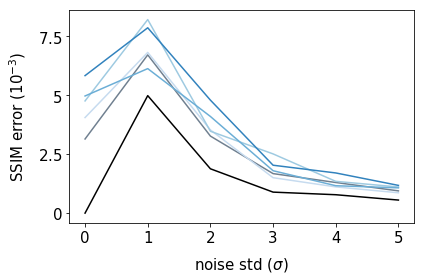

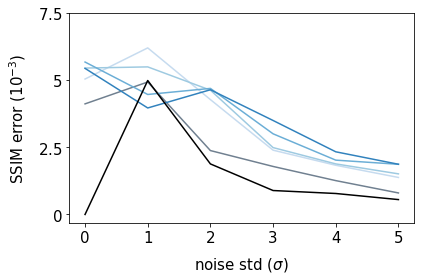

In [16]:
save_fig = False
color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]
std_list = Exp['std_list']


std_ssim = (Exp['ssim'] - Exp['ssim'].median(dim=0)[0].unsqueeze(0)).abs()
std_ssim = std_ssim.median(dim=0)[0]


std_ssim_baseline = (Exp['ssim_baseline'] - Exp['ssim_baseline'].median(dim=0)[0].unsqueeze(0)).abs()
std_ssim_baseline = std_ssim_baseline.median(dim=0)[0]

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    std_0 = std_ssim[:,idx_b,0]
    plt.plot(std_list ,std_0.numpy(),label='b={0}'.format(b),color=color[idx_b])
plt.plot(std_list,std_ssim_baseline.numpy(), color='black')

plt.ylabel('SSIM error ' + r'($10^{-3}$)' , fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0,0.0025,0.005,0.0075], \
           [r'$0$',r'$2.5$',r'$5$',r'$7.5$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS5/FigS5d.png',\
                bbox_inches = 'tight', pad_inches = 0.02, dpi= 400)

plt.show()

fig = plt.figure()
for idx_b, b in enumerate(b_list):
    std_0 = std_ssim[:,idx_b,1]
    plt.plot(std_list ,std_0.numpy(),label='b={0}'.format(b),color=color[idx_b])
plt.plot(std_list,std_ssim_baseline.numpy(), color='black')

plt.ylabel('SSIM error ' + r'($10^{-3}$)' , fontsize=15, labelpad=10)

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0,0.0025,0.005,0.0075], \
           [r'$0$',r'$2.5$',r'$5$',r'$7.5$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/FigS5/FigS5e.png',\
                bbox_inches = 'tight', pad_inches = 0.02, dpi= 400)

plt.show()




## Fig 12

### Inference for different value of lbda1 and different noise level

In [17]:
data_path = '../DataSet/STL10'
batch_size=40
transform = Compose([Resize((120,120)),
                    ToTensor(),
                    to_cuda(),
                    whitening((120,120),f_0=0.8,n=3),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((120,120))])
                     

dataset = STL10(data_path, transform=transform, download=False, split='train')

DataBase = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [18]:
where = 'Savings/STL/'
model_name = 'STL_[0.4,1.6]_b=1.pkl'

feedback_list = [4]



#save_simulation = False

#path_saving = 'Simulation/SSIM=f(std)_lbda1_STL.pkl'


lbda1_list = [0.0,1.5,3.0]
std_list = [0,1,2,3,4,5]
all_reco = torch.zeros(len(std_list),len(feedback_list),2,3,120,120)
noisy_input = torch.zeros(len(std_list),3,120,120)
nb_image = 40
#all_ssim = torch.zeros(nb_image,len(lbda1_list),2)
nb_batch = 10
all_ssim = torch.zeros(nb_batch,len(std_list),len(lbda1_list),2)
#print(all_ssim.size())
            
ssim_baseline = torch.zeros(nb_batch,len(std_list))
#if save_simulation == True:
for idx_k, k_FB in enumerate(feedback_list):
    for lbda1_idx, lbda1 in enumerate(lbda1_list) : 
        model_type = model_name[0:8]
        name = model_name
        print(name)

        path = where + name
        with open(path, 'rb') as file:
            out = pickle.load(file)
        Net = out['Net']

        for i in range(Net.nb_layers):
            Net.layers[i].b = k_FB
        Loss = ML_Lasso(Net, [lbda1,1.6])
        print('Exp [{0},1.6]'.format(lbda1))

        Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=5e-3, mode='eigen', accell=True)
        #Loss = out['Loss']
        #Pursuit = out['Pursuit']
        for noise_idx, std in enumerate(std_list):
            k=0
            for idx_batch, data in enumerate(DataBase):

                image_ori = data[0].cuda()
                batch = data[0].cuda() + std*torch.randn(data[0].size()).cuda()

                gamma, it, Loss_G, delta = Pursuit.coding(batch)
                print(it)
                rec = reconstruction(Net,gamma)

                normalizer = image_ori.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_image = image_ori.div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))


                normalizer_noisy = batch.view(data[0].size(0),-1).max(dim=1)[0]
                normalized_noisy = batch.div(normalizer_noisy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

                ssim_baseline[idx_batch,noise_idx] = ssim(normalized_image,normalized_noisy)

                for i in range(Net.nb_layers):
                    normalizer = rec[i].view(data[0].size(0),-1).max(dim=1)[0]
                    normalized_reco = rec[i].div(normalizer.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))

                    #all_ssim[k:k+batch.size(0),lbda1_idx,i] += ssim(normalized_image,normalized_reco)                
                    all_ssim[idx_batch,noise_idx,lbda1_idx,i] = ssim(normalized_image,normalized_reco)                
                    #print(ssim(normalized_image,normalized_reco))
                    #print(all_ssim)
                    all_reco[noise_idx,idx_k,i, :,:,:]=normalized_reco[9,:,:,:]
                noisy_input[noise_idx, :,:,:]=batch[9,:,:,:]

                k+=batch.size(0)
                if idx_batch >= nb_batch-1:
                    break

Exp = {'model_name': feedback_list,
       'std_list':std_list,
        'ssim' : all_ssim,
        'reco':all_reco,
        'noisy_input':noisy_input,
        'ssim_baseline':ssim_baseline}

'''
    with open(path_saving, 'wb') as file:
        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)
else : 
    with open(path_saving, 'rb') as file:
        Exp = pickle.load(file)
'''

STL_[0.4,1.6]_b=1.pkl
Exp [0.0,1.6]
23
24
24
23
23
23
24
24
23
24
19
20
20
19
19
20
20
19
19
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
STL_[0.4,1.6]_b=1.pkl
Exp [1.5,1.6]
21
21
21
21
21
21
21
21
21
21
20
20
20
20
20
20
20
20
20
20
9
9
9
9
9
9
9
9
9
9
19
10
10
10
10
19
10
10
19
19
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
STL_[0.4,1.6]_b=1.pkl
Exp [3.0,1.6]
20
20
20
20
20
20
21
20
20
20
20
20
20
20
20
20
20
20
20
20
8
19
19
9
19
19
19
19
8
19
9
19
19
19
9
19
19
9
9
19
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


"\n    with open(path_saving, 'wb') as file:\n        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)\nelse : \n    with open(path_saving, 'rb') as file:\n        Exp = pickle.load(file)\n"

tensor([1.0000, 0.1878, 0.0720, 0.0385, 0.0250, 0.0181])
torch.Size([6, 3])


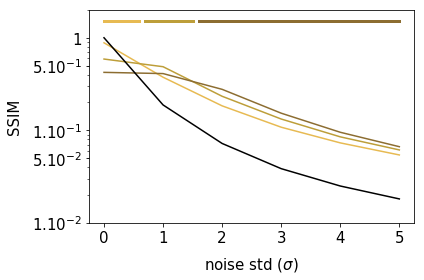

torch.Size([6, 3])


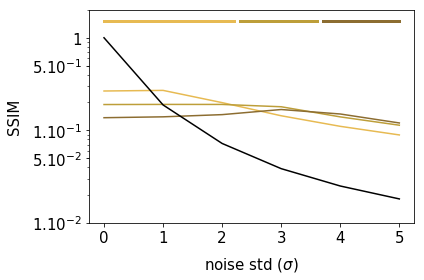

In [20]:
save_fig = False
all_ssim = Exp['ssim']
ssim_bl = Exp['ssim_baseline']
mean_ssim_baseline = ssim_bl.mean(dim=0)
mean_ssim = all_ssim.mean(dim=0)[:,:,0]
print(mean_ssim_baseline)
cmap2=plt.get_cmap('tab20b')
#color_lbda=[cmap2(6),cmap2(5),cmap2(4)]
color_lbda=[cmap2(10),cmap2(9),cmap2(8)]


print(mean_ssim.size())


fig = plt.figure()
for idx_lbda, lbda1 in enumerate(lbda1_list):
    plt.plot(std_list ,mean_ssim[:,idx_lbda].numpy(),label=r'$\lambda_{1}=$'+'{0}'.format(lbda1),color=color_lbda[idx_lbda])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.plot([0.0,0.6],[1.5,1.5], linewidth=3, color=color_lbda[0])
plt.plot([0.7,1.5],[1.5,1.5], linewidth=3, color=color_lbda[1])
plt.plot([1.6,5],[1.5,1.5], linewidth=3, color=color_lbda[2])

#plt.arrow(0, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color='black')
#plt.arrow(0, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[0])
#plt.arrow(0.6, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[1])
#plt.arrow(1.5,1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[2])

plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)

plt.ylim((0,2))

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig12/Fig12a.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
plt.show()

all_ssim = Exp['ssim']
mean_ssim = all_ssim.mean(dim=0)[:,:,1]
print(mean_ssim.size())


fig = plt.figure()
for idx_lbda, lbda1 in enumerate(lbda1_list):
    plt.plot(std_list ,mean_ssim[:,idx_lbda].numpy(),label=r'$\lambda_{1}=$'+'{0}'.format(lbda1),color=color_lbda[idx_lbda])

plt.plot(std_list,mean_ssim_baseline.numpy(), label='baseline',color='black')

plt.plot([0.0,2.2],[1.5,1.5], linewidth=3, color=color_lbda[0])
plt.plot([2.3,3.6],[1.5,1.5], linewidth=3, color=color_lbda[1])
plt.plot([3.7,5],[1.5,1.5], linewidth=3, color=color_lbda[2])

#plt.arrow(0, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color='black')
#plt.arrow(0, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[0])
#plt.arrow(2.2, 1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[1])
#plt.arrow(3.6,1.6, 0, -0.4, length_includes_head=True, head_width=0.1, head_length=0.1, linewidth=1.5, color=color_lbda[2])

plt.yscale("log")
plt.ylabel('SSIM', fontsize=15, labelpad=10)

plt.ylim((0,2))

plt.xlabel('noise std ' + r'$(\sigma)$', fontsize=15, labelpad=10)
plt.xticks(std_list, fontsize=15)
plt.yticks([0.01,0.05,0.1,0.5,1], \
           [r'$1.10^{-2}$',r'$5.10^{-2}$',r'$1.10^{-1}$',r'$5.10^{-1}$',r'$1$'], fontsize=15)
if save_fig == True:
    plt.tight_layout()
    plt.savefig('Savings/Fig/Fig12/Fig12b.png',\
                bbox_inches = 'tight', pad_inches = 0, dpi= 400)

#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
plt.show()